# Problem Statement
We want to create a text summarizer model that takes a review and returns the summary of it.

- Data: using "Samsum" data
    - https://huggingface.co/datasets/samsum
- Model: facebook/bart-large-cnn"  
    - https://huggingface.co/facebook/bart-large-cnn  
We are going to fune-tune the model to work for samsum dataset

In [1]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

In [2]:
from transformers import pipeline, AutoModelForSeq2SeqLM, AutoTokenizer
import matplotlib.pyplot as plt
from datasets import load_dataset, load_metric
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
model_ckpt = "facebook/bart-large-cnn"

# loading the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [5]:
model_summarizer = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [6]:
# load data
dataset = load_dataset("samsum")

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [8]:
print(dataset['train'][0]['dialogue'])

Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)


In [9]:
print(dataset['train'][0]['summary'])

Amanda baked cookies and will bring Jerry some tomorrow.


In [10]:
dialogue = dataset['test'][0]['dialogue']
print(dialogue)

Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye


In [11]:
pipe = pipeline(task="summarization", model=model_ckpt)

In [12]:
# testing if the model works without fine-tuning it
prediction = pipe(dialogue)
print(prediction[0]['summary_text'])

Your max_length is set to 142, but your input_length is only 139. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


Hannah asks Amanda for Betty's number. Amanda can't find it. Hannah asks Larry. Amanda asks Larry to text him. Hannah says she'll text him back. Hannah calls it a day and says she's going to go home. Hannah: "Bye bye"


In [13]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [14]:
# selecting just 10 samples, so it doesn't take a lot of time
sample_test_data = dataset['test'][:10]

In [15]:
rouge_metric = load_metric("rouge")

score = calculate_metric_on_test_ds(dataset=sample_test_data, metric=rouge_metric, model=model_summarizer,
                                    tokenizer=tokenizer, batch_size=16, device=device, column_text="dialogue", column_summary="summary")

<ipython-input-15-e660cda8d7d9>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric("rouge")
100%|██████████| 1/1 [00:08<00:00,  8.48s/it]


In [16]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['bart'])

,rouge1,rouge2,rougeL,rougeLsum
bart,0.016443,0.0,0.01663,0.016482


So bad, need to fune-tune it :)

Token indices sequence length is longer than the specified maximum sequence length for this model (1081 > 1024). Running this sequence through the model will result in indexing errors


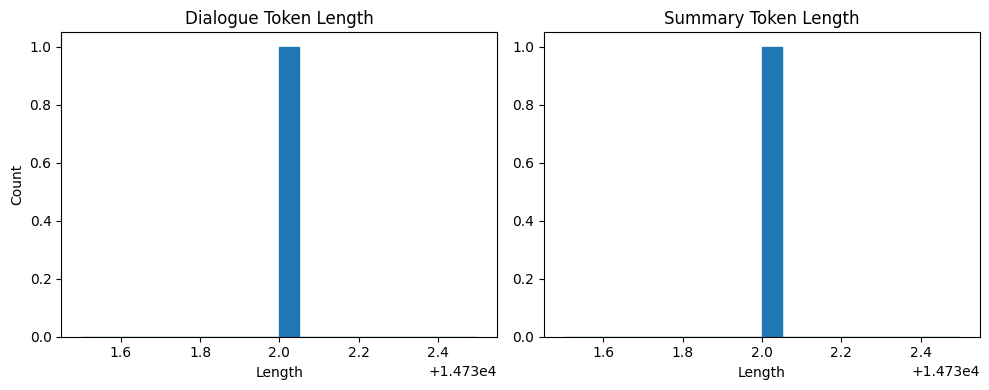

In [17]:
dialogue_token_len = len([tokenizer.encode(s) for s in dataset['train']['dialogue']])

summary_token_len = len([tokenizer.encode(s) for s in dataset['train']['summary']])


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [18]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [19]:
sample_encoding = dataset_samsum_pt['train'][0]
sample_encoding['id'], sample_encoding['dialogue'], sample_encoding['summary']

('13818513',
 "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'Amanda baked cookies and will bring Jerry some tomorrow.')

In [20]:
sample_encoding['input_ids'], sample_encoding['attention_mask'], sample_encoding['labels']

([0,
  10127,
  5219,
  35,
  38,
  17241,
  1437,
  15269,
  4,
  1832,
  47,
  236,
  103,
  116,
  50121,
  50118,
  39237,
  35,
  9136,
  328,
  50121,
  50118,
  10127,
  5219,
  35,
  38,
  581,
  836,
  47,
  3859,
  48433,
  2],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [0, 10127, 5219, 17241, 15269, 8, 40, 836, 6509, 103, 3859, 4, 2])

In [21]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collector = DataCollatorForSeq2Seq(tokenizer, model=model_summarizer)

In [22]:
!pip install transformers[torch]

In [23]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='bart-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
)


trainer = Trainer(model=model_summarizer, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collector,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

trainer.train()

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,1.436700,1.475281


TrainOutput(global_step=920, training_loss=1.386543481246285, metrics={'train_runtime': 2444.4252, 'train_samples_per_second': 6.027, 'train_steps_per_second': 0.376, 'total_flos': 4938562616451072.0, 'train_loss': 1.386543481246285, 'epoch': 1.0})

This was trained on colab since training it locally is impossible

In [24]:
# testing the score again to see if it's improved
score = calculate_metric_on_test_ds(
    sample_test_data, rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'bart'] )

100%|██████████| 5/5 [00:19<00:00,  3.85s/it]


,rouge1,rouge2,rougeL,rougeLsum
bart,0.016005,0.0,0.016249,0.015898


In [ ]:
# rouge1	rouge2	rougeL	rougeLsum
# bart	0.016443	0.0	0.01663	0.016482

In [25]:
# save pretrained model and the tokenizer
model_summarizer.save_pretrained("tuned-bart-samsum")

tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [26]:
dataset_samsum_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [27]:
# to download the model and tokenizer
!zip -r /content/tokenizer.zip /content/tokenizer

  adding: content/tokenizer/ (stored 0%)
  adding: content/tokenizer/tokenizer_config.json (deflated 76%)
  adding: content/tokenizer/special_tokens_map.json (deflated 52%)
  adding: content/tokenizer/vocab.json (deflated 59%)
  adding: content/tokenizer/merges.txt (deflated 53%)
  adding: content/tokenizer/tokenizer.json (deflated 72%)


In [28]:
!zip -r /content/tuned-bart-samsum.zip /content/tuned-bart-samsum

  adding: content/tuned-bart-samsum/ (stored 0%)
  adding: content/tuned-bart-samsum/model.safetensors (deflated 7%)
  adding: content/tuned-bart-samsum/generation_config.json (deflated 47%)
  adding: content/tuned-bart-samsum/config.json (deflated 61%)


In [31]:
from google.colab import files
files.download("/content/tuned-bart-samsum.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference using our trained (tuned) model

tokenizer and tuned-bart-samsum that are in artifacts are created then downloaded through google colab

In [29]:
!pwd

/content


In [30]:
!ls

bart-samsum  sample_data  tokenizer  tokenizer.zip  tuned-bart-samsum  tuned-bart-samsum.zip


In [8]:
from transformers import pipeline, AutoTokenizer
from datasets import load_dataset

In [6]:
tokenizer = AutoTokenizer.from_pretrained("../artifacts/tokenizer")

In [9]:
dataset = load_dataset("samsum")

sample_text = dataset["test"][0]["dialogue"]
reference = dataset["test"][0]["summary"]

In [10]:
print(sample_text)

Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye


In [11]:
reference

"Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry."

In [12]:
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}

pipe = pipeline("summarization", model="tuned-bart-samsum", tokenizer=tokenizer)

OSError: tuned-bart-samsum is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [37]:
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Amanda can't find Betty's number. Larry called Betty the last time they were at the park together. Hannah advises Amanda to text him to ask him for Betty's phone number. Hannah and Larry don't know each other well, so Hannah would rather Amanda texted him.
